In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower

In [16]:
#constants
ombh2 = 0.022445
n_s = 0.96

#baselines
sig8_b = 0.82755
# Lbox_b = 1000 # I don't think CAMB has this
wa_b = 0.00
w0_b = -1.00
OmK_b = 0
OmL_b = 0.681415906
omch2_b = 0.120567
mnu_b = 0.00
h_b = 0.67
# derived quantities
H0_b = 100 * h_b

omega_nu = [0.0006356, 0.002, 0.006356]

baseline = {
    "H0": H0_b,
    "ombh2": ombh2,
    "omch2": omch2_b,
    "omk": OmK_b,
    "tau": 0.06, # not specified by provided data table
    "w": w0_b,
    "wa": wa_b,
    "ns": 0.96
}
As = [
    2.12723788013000E-09,
    1.78568440085517E-09,
    2.48485942677850E-09,
    2.32071013846548E-09,
    1.99553701204688E-09,
    2.07077004294502E-09,
    2.20196413682945E-09,
    1.92961581654148E-09,
    2.29291725000000E-09
]

cosm = [] # cosmologies
# This order ensures that the indices are the same
# before and after applying CAMB.
redshifts = [4, 3, 2, 1, 0]

In [22]:
for i in range(9):
    cosm.append(baseline.copy())
    cosm[i]["As"] = As[i]
    
cosm[1]["H0"] = 55
cosm[2]["H0"] = 79

In [27]:
def kzps(mlc, omnuh2_in, massive_neutrinos=False, sigma12_in=1):
    """
    Returns the scale axis, redshifts, power spectrum, and sigma12
    of a Lambda-CDM model
    @param mlc : "MassLess Cosmology"
        a dictionary of values
        for CAMBparams fields
    @param omnuh2_in : neutrino physical mass density
    @param sigma12 : if the spectrum should be rescaled,
        this parameter determines the desired sigma12 of the model
    @massive_neutrinos : if this is True,
        the value in omnuh2_in is used to set omnuh2.
        If this is False,
        the value in omnuh2_in is simply added to omch2.
        
    warning: this function currently supports only one redshift,
        z = 0. This is not for difficulty of implementation,
        but only to make absolutely sure that our toy example
        is simple until we've understood the basics.
    """
    pars = camb.CAMBparams()
    omch2_in = mlc["omch2"] + omnuh2_in
    if massive_neutrinos:
        omch2_in = mlc["omch2"]
        pars.omnuh2=omnuh2_in
    pars.set_cosmology(
        H0=mlc["H0"],
        ombh2=mlc["ombh2"],
        omch2=omch2_in,
        omk=mlc["omk"],
        tau=mlc["tau"])
    pars.InitPower.set_params(As=mlc["As"], ns=mlc["ns"])
    pars.set_dark_energy(w=mlc["w"], wa=mlc["wa"])
    
    pars.set_matter_power(redshifts=[0.], kmax=2.0)
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)
    
    if sigma12_in != 1:
        sigma12_unmodified = results.get_sigmaR(12, hubble_units=False)
        As_rescaled = 2e-9 * (sigma12_in / sigma12_unmodified) ** 2

        pars.InitPower.set_params(As=As_rescaled, ns=mlc["ns"])

    k, z, p = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
    sigma12 = results.get_sigmaR(12, hubble_units=False)
    return k, z, p, sigma12

In [48]:
# Let us begin our demonstration by considering only the
# middle of the
# given neutrino mass physical densities, omega_nu[1]
k_list = []
z_list = []
p_list = []
s12_list = []

for cosmology in cosm:
    k, z, p, s12 = kzps(cosmology, omega_nu[1], massive_neutrinos=False)
    k_list.append(k)
    z_list.append(z)
    p_list.append(p)
    s12_list.append(s12)
    k, z, p, s12 = kzps(cosmology, omega_nu[1], massive_neutrinos=True,
                       sigma12_in=s12)
    k_list.append(k)
    z_list.append(z)
    p_list.append(p)
    s12_list.append(s12)

#kmassive, zmassive, pmassive, sigma12 = kzps(cosm[0], omega_nu[1], massive_neutrinos=True)
#kmassless, zmassless, pmassless, sigma12 = kzps(cosm[0], omega_nu[1], massive_neutrinos=False)

NameError: name 'omch2_modifier' is not defined

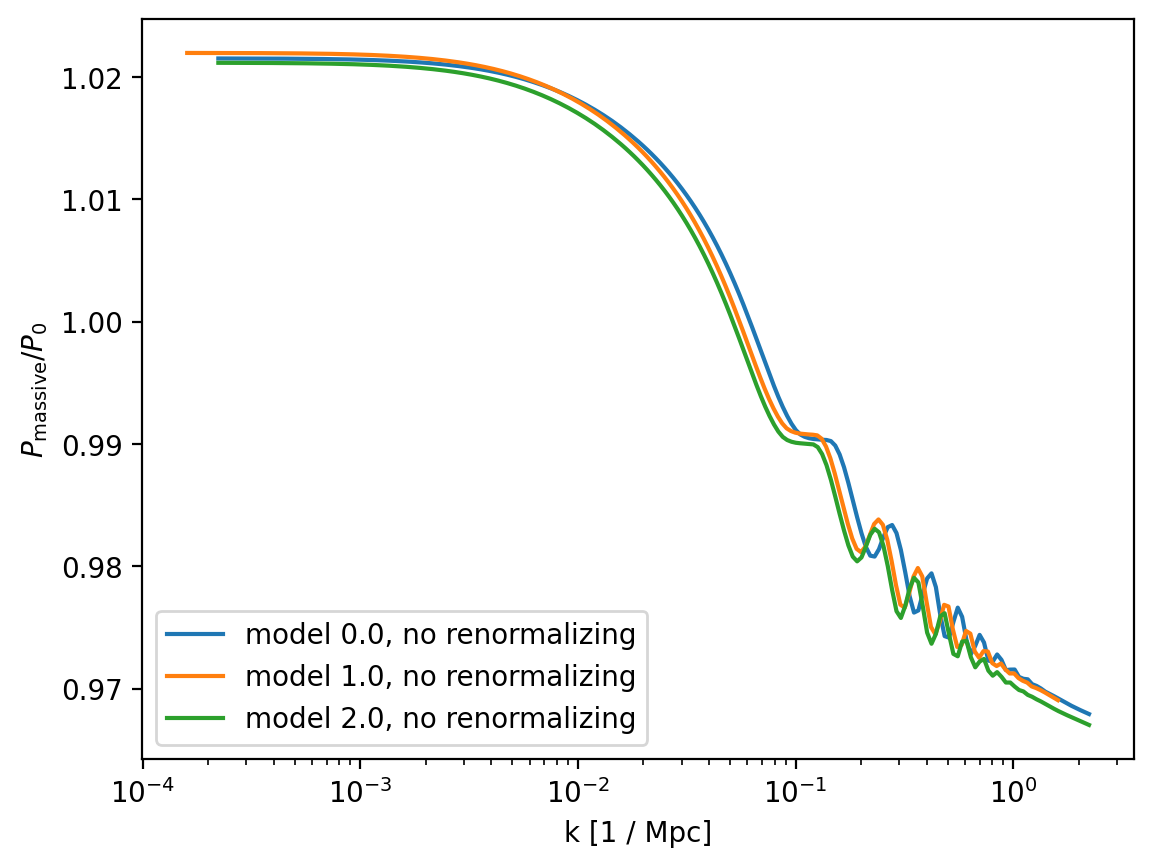

In [47]:
for i in range(0, 5, 2):
    h = cosm[i]["H0"] / 100
    plt.plot(k_list[i] / h ** 2, p_list[i][0] / p_list[i + 1][0],
             label="model " + str(i / 2) + ", no renormalizing")
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.legend()

In [3]:
massive = []
massless = []

mnu_start = 0.06
mstep = 0.02
for i in range(0, 4):
    msum = mnu_start + mstep * i
    label = r"$\Sigma m_\nu = $" + str(msum) + " [eV]"
    k, z, p, s, omnuh2 = kzps(msum, 1)
    massive.append((label, k, z, p, s))
    label0 = r"$\Sigma m_\nu = 0$ norm'd to " + str(msum)
    k0, z0, p0, s0, omnuh2 = kzps(0, s, omnuh2)
    massless.append((label0, k0, z0, p0, s0))

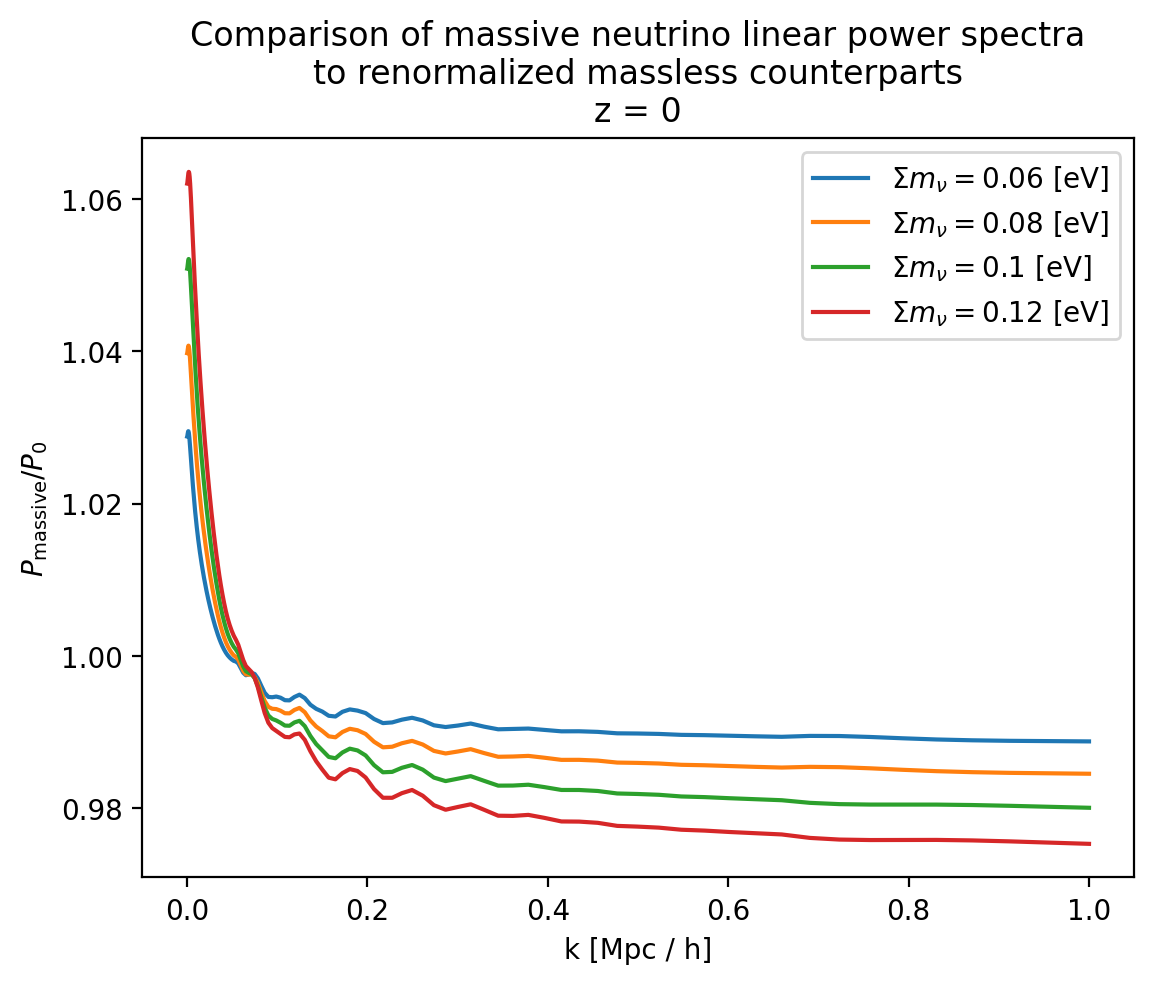

In [4]:
for i in range(len(massive)):
    plt.plot(massive[i][1], massive[i][3][0] / massless[i][3][0], label=massive[i][0])

title = "Comparison of massive neutrino linear power spectra\n" + \
    "to renormalized massless counterparts\n" + \
    "z = 0"
plt.title(title)
plt.xlabel(r"k [h / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.legend()

Ivanov 2021 ("Cosmological Constraints...") puts the limit at M_tot < 0.64 eV 95% CL.

Planck 2018 data apparently puts the limit at M_tot < 0.12 eV for 95% CL.

    This is cited in Amiri et al, 2021 ("Constraining neutrino mass...")

Font-Ribera et al. 2014 ("DESI and other...") puts the limit at M_tot > 0.06 eV.

Problems? and problems:
* Ariel's x-axis has 1 / Mpc, but mine has h / Mpc.
    * I think I've fixed this problem by dividing my result by h^2
* I am currently not re-normalizing the amplitude of one model mased on its counterpart. At least, I *think* I'm not doing that.
* I need to set a k_min value so that the x axes align better